In [1]:
import os
import glob
import numpy as np
import pandas as pd
from scipy import fftpack
from scipy.stats import zscore, multivariate_normal
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
import joblib

In [12]:
# -------------------------
# PARAMETERS
# -------------------------
DATA_FOLDERS = {
    'jump': 'datasets/final_jump_data',
    'walking': 'datasets/final_walking_data',
    'stand': 'datasets/final_stand_data',
    'still': 'datasets/final_still_data'
}
FS = 100  # sampling frequency (Hz)
WINDOW_SEC = 1.0  # 1-second windows
WINDOW_STEP = 0.5  # seconds (50% overlap)
N_PCA = 10  # optional dimensionality reduction for HMM emissions
N_COMPONENTS_HMM = 4  # 4 hidden states (jump, walking, stand, still)
RANDOM_STATE = 42

In [3]:
# -------------------------
# 1) LOAD DATA
# -------------------------

def load_all_sessions(data_folders):
    """Load CSVs from labeled folders. Returns list of dicts: {'activity', 'file', 'df'}"""
    sessions = []
    for label, folder in data_folders.items():
        files = sorted(glob.glob(os.path.join(folder, '*.csv')))
        for f in files:
            df = pd.read_csv(f)
            # Ensure expected columns
            expected = ['seconds_elapsed','ax','ay','az','gx','gy','gz']
            if not all(c in df.columns for c in expected):
                raise ValueError(f"File {f} missing expected columns. Found: {df.columns.tolist()}")
            sessions.append({'activity': label, 'file': f, 'df': df[expected].copy()})
    return sessions

sessions = load_all_sessions(DATA_FOLDERS)
print(f"Loaded {len(sessions)} sessions")


Loaded 102 sessions


In [4]:
# -------------------------
# 2) WINDOWING
# -------------------------

def sliding_windows(df, window_sec=WINDOW_SEC, step_sec=WINDOW_STEP, fs=FS):
    n_win = int(round(window_sec * fs))
    step = int(round(step_sec * fs))
    data = df[['ax','ay','az','gx','gy','gz']].values
    starts = np.arange(0, len(df) - n_win + 1, step)
    windows = []
    for s in starts:
        win = data[s:s+n_win]
        windows.append({'start_idx': s, 'window': win, 'seconds': df['seconds_elapsed'].iloc[s]})
    return windows


In [5]:
# -------------------------
# 3) FEATURE EXTRACTION
# -------------------------

def compute_time_features(win):
    # win shape: (n_samples, 6) -> ax,ay,az,gx,gy,gz
    feats = {}
    accel = win[:,0:3]
    gyro = win[:,3:6]
    # Time-domain: per-axis mean, std, var, rms, ptp
    for i, name in enumerate(['ax','ay','az']):
        x = accel[:,i]
        feats[f'{name}_mean'] = np.mean(x)
        feats[f'{name}_std'] = np.std(x)
        feats[f'{name}_var'] = np.var(x)
        feats[f'{name}_rms'] = np.sqrt(np.mean(x**2))
        feats[f'{name}_ptp'] = np.ptp(x)
    for i, name in enumerate(['gx','gy','gz']):
        x = gyro[:,i]
        feats[f'{name}_mean'] = np.mean(x)
        feats[f'{name}_std'] = np.std(x)
        feats[f'{name}_var'] = np.var(x)
        feats[f'{name}_rms'] = np.sqrt(np.mean(x**2))
        feats[f'{name}_ptp'] = np.ptp(x)
    # SMA for accel
    feats['acc_sma'] = np.sum(np.abs(accel)) / accel.shape[0]
    # Correlations between axes (accel)
    feats['acc_corr_xy'] = np.corrcoef(accel[:,0], accel[:,1])[0,1]
    feats['acc_corr_xz'] = np.corrcoef(accel[:,0], accel[:,2])[0,1]
    feats['acc_corr_yz'] = np.corrcoef(accel[:,1], accel[:,2])[0,1]
    return feats

def compute_freq_features(win, fs=FS):
    feats = {}
    n = win.shape[0]
    accel = win[:,0:3]
    gyro = win[:,3:6]
    # For each axis compute dominant frequency and spectral energy
    for i, name in enumerate(['ax','ay','az']):
        x = accel[:,i]
        X = np.fft.rfft(x)
        P = np.abs(X)**2
        freqs = np.fft.rfftfreq(n, 1/fs)
        dominant = freqs[np.argmax(P)]
        feats[f'{name}_domfreq'] = dominant
        feats[f'{name}_specenergy'] = np.sum(P)
    for i, name in enumerate(['gx','gy','gz']):
        x = gyro[:,i]
        X = np.fft.rfft(x)
        P = np.abs(X)**2
        freqs = np.fft.rfftfreq(n, 1/fs)
        dominant = freqs[np.argmax(P)]
        feats[f'{name}_domfreq'] = dominant
        feats[f'{name}_specenergy'] = np.sum(P)
    return feats

def extract_features_from_windows(windows):
    feat_list = []
    for w in windows:
        win = w['window']
        tfeats = compute_time_features(win)
        ffeats = compute_freq_features(win)
        merged = {**tfeats, **ffeats}
        merged['start_idx'] = w['start_idx']
        merged['seconds'] = w['seconds']
        feat_list.append(merged)
    return pd.DataFrame(feat_list)


In [6]:
# -------------------------
# 4) BUILD FEATURE DATASET PER SESSION
# -------------------------

all_feature_sessions = []  # list of dicts with: activity, file, features_df
for s in sessions:
    windows = sliding_windows(s['df'])
    feats = extract_features_from_windows(windows)
    feats['activity'] = s['activity']
    feats['file'] = os.path.basename(s['file'])
    all_feature_sessions.append({'activity': s['activity'], 'file': s['file'], 'features': feats})

print('Extracted features for', len(all_feature_sessions), 'sessions')

# Concatenate to a single DataFrame for convenience
features_df = pd.concat([fs['features'] for fs in all_feature_sessions], ignore_index=True)
print('Total windows:', len(features_df))


Extracted features for 102 sessions
Total windows: 1270


In [7]:
# -------------------------
# 5) PREPROCESS FEATURES FOR HMM
# -------------------------

# Drop columns not used as features
non_feature_cols = ['start_idx','seconds','activity','file']
feature_cols = [c for c in features_df.columns if c not in non_feature_cols]
X_raw = features_df[feature_cols].fillna(0).values
# Z-score normalize across the dataset
X_norm = zscore(X_raw, axis=0)
# Optional PCA to reduce dimensionality for HMM emissions
pca = PCA(n_components=min(N_PCA, X_norm.shape[1]), random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_norm)
print('Features -> PCA dims:', X_pca.shape)


Features -> PCA dims: (1270, 10)


In [8]:
# -------------------------
# 6) PREPARE SEQUENCES (concatenate by session) for HMM training
# -------------------------
lengths = [len(fs['features']) for fs in all_feature_sessions]
# order of concatenation matches all_feature_sessions
X_concat = np.vstack([fs['features'][feature_cols].fillna(0).values for fs in all_feature_sessions])
X_concat_norm = zscore(X_concat, axis=0)
X_concat_pca = pca.transform(X_concat_norm)

# Keep labels per window for evaluation
labels_concat = np.concatenate([fs['features']['activity'].values for fs in all_feature_sessions])
filenames_concat = np.concatenate([np.repeat(os.path.basename(fs['file']), len(fs['features'])) for fs in all_feature_sessions])


In [9]:
# -------------------------
# 7) TRAIN HMM (Baum-Welch via hmmlearn)
# -------------------------
model = hmm.GaussianHMM(n_components=N_COMPONENTS_HMM, covariance_type='full', n_iter=200, random_state=RANDOM_STATE)
# Initialize means using KMeans-like (hmmlearn has init params; skipping KMeans to keep simple)
model.fit(X_concat_pca, lengths=lengths)
print('HMM trained. Score:', model.score(X_concat_pca, lengths))

# Save model & PCA
joblib.dump(model, 'hmm_model.joblib')
joblib.dump(pca, 'pca.joblib')


HMM trained. Score: -5364.67915272959


['pca.joblib']

In [10]:
# -------------------------
# 8) VITERBI implementation (uses learned model params)
# -------------------------

def viterbi_log(obs, startprob, transmat, means, covars):
    # obs: (T, D)
    T = obs.shape[0]
    N = startprob.shape[0]
    log_start = np.log(startprob + 1e-12)
    log_trans = np.log(transmat + 1e-12)
    # Precompute log likelihoods using multivariate normal
    log_lik = np.zeros((T, N))
    for k in range(N):
        rv = multivariate_normal(mean=means[k], cov=covars[k], allow_singular=True)
        log_lik[:, k] = rv.logpdf(obs)
    # delta and psi
    delta = np.full((T, N), -np.inf)
    psi = np.zeros((T, N), dtype=int)
    delta[0] = log_start + log_lik[0]
    for t in range(1, T):
        for j in range(N):
            seq_probs = delta[t-1] + log_trans[:, j]
            psi[t, j] = np.argmax(seq_probs)
            delta[t, j] = seq_probs[psi[t, j]] + log_lik[t, j]
    # Backtrack
    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(delta[-1])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states

# Use model parameters
startprob = model.startprob_
transmat = model.transmat_
means = model.means_
covars = model.covars_

# Decode the entire concatenated sequence
decoded_states = viterbi_log(X_concat_pca, startprob, transmat, means, covars)


In [11]:
# -------------------------
# 9) Map HMM states to ground-truth activities
# -------------------------
# HMM state indices are arbitrary; we map them to activities by majority vote within each HMM state
state_to_activity = {}
for s in range(N_COMPONENTS_HMM):
    mask = decoded_states == s
    if mask.sum() == 0:
        state_to_activity[s] = 'unknown'
    else:
        vals, counts = np.unique(labels_concat[mask], return_counts=True)
        state_to_activity[s] = vals[np.argmax(counts)]
print('State -> activity mapping:', state_to_activity)

predicted_activity = np.array([state_to_activity[s] for s in decoded_states])


State -> activity mapping: {0: 'stand', 1: 'jump', 2: 'jump', 3: 'still'}


In [13]:
# -------------------------
# 10) Evaluation (overall & per-state metrics)
# -------------------------
activities = np.unique(labels_concat)
cm = confusion_matrix(labels_concat, predicted_activity, labels=activities)
print('Confusion matrix (rows true, cols pred)')
print(pd.DataFrame(cm, index=activities, columns=activities))
print('\nClassification report:')
print(classification_report(labels_concat, predicted_activity, zero_division=0))

# Per-state sensitivity, specificity, accuracy table
results = []
total = cm.sum()
for i, act in enumerate(activities):
    TP = cm[i,i]
    FN = cm[i,:].sum() - TP
    FP = cm[:,i].sum() - TP
    TN = total - TP - FN - FP
    sensitivity = TP / (TP + FN) if (TP + FN)>0 else 0
    specificity = TN / (TN + FP) if (TN + FP)>0 else 0
    overall_acc = (TP + TN) / total
    results.append({'activity': act, 'samples': cm[i,:].sum(), 'sensitivity': sensitivity, 'specificity': specificity, 'overall_accuracy': overall_acc})

results_df = pd.DataFrame(results)
print('\nPer-state metrics:')
print(results_df)


Confusion matrix (rows true, cols pred)
         jump  stand  still  walking
jump      383      2      0        0
stand       1    274      0        0
still       0      0    336        0
walking    50    224      0        0

Classification report:
              precision    recall  f1-score   support

        jump       0.88      0.99      0.94       385
       stand       0.55      1.00      0.71       275
       still       1.00      1.00      1.00       336
     walking       0.00      0.00      0.00       274

    accuracy                           0.78      1270
   macro avg       0.61      0.75      0.66      1270
weighted avg       0.65      0.78      0.70      1270


Per-state metrics:
  activity  samples  sensitivity  specificity  overall_accuracy
0     jump      385     0.994805     0.942373          0.958268
1    stand      275     0.996364     0.772864          0.821260
2    still      336     1.000000     1.000000          1.000000
3  walking      274     0.000000     1.0


Saved figures and results to working directory.


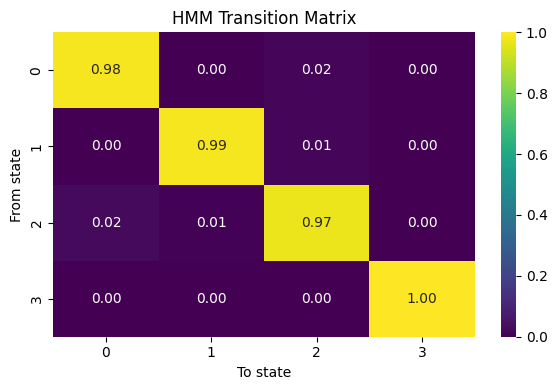

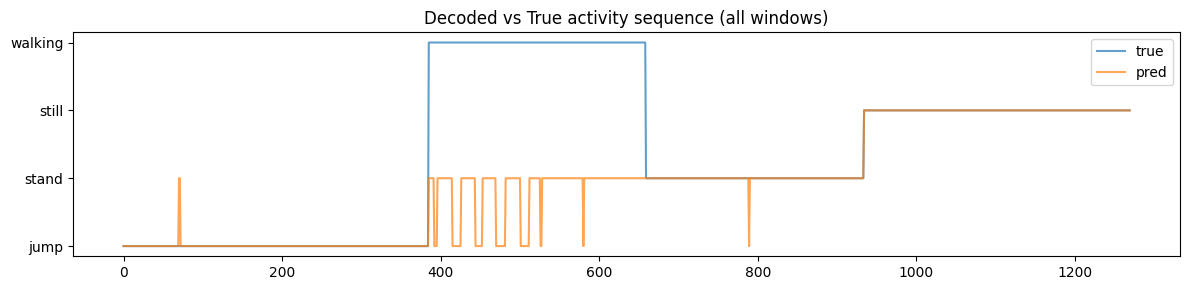

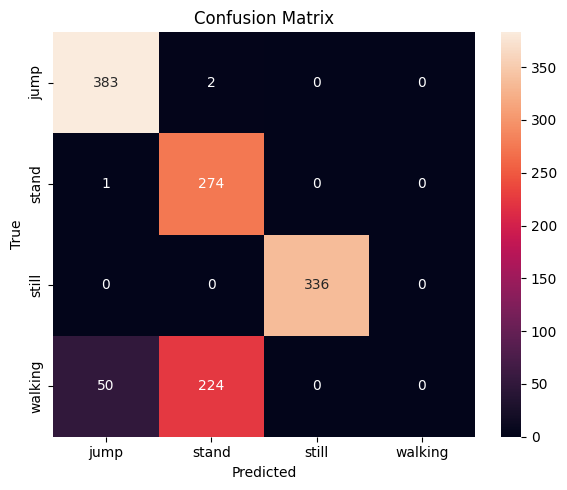

In [14]:
# -------------------------
# 11) Visualizations
# -------------------------

# Transition matrix heatmap
plt.figure(figsize=(6,4))
ax = sns.heatmap(transmat, annot=True, fmt='.2f', cmap='viridis')
ax.set_title('HMM Transition Matrix')
ax.set_xlabel('To state')
ax.set_ylabel('From state')
plt.tight_layout()
plt.savefig('transition_matrix_heatmap.png', dpi=150)

# Timeline: show a segment of ground truth vs predicted (first concatenated file length)
plt.figure(figsize=(12,3))
# convert activities to integers for plotting
act_to_int = {a:i for i,a in enumerate(activities)}
true_ints = np.array([act_to_int[a] for a in labels_concat])
pred_ints = np.array([act_to_int[a] for a in predicted_activity])
plt.plot(true_ints, label='true', alpha=0.7)
plt.plot(pred_ints, label='pred', alpha=0.7)
plt.yticks(list(act_to_int.values()), list(act_to_int.keys()))
plt.legend()
plt.title('Decoded vs True activity sequence (all windows)')
plt.tight_layout()
plt.savefig('decoded_timeline.png', dpi=150)

# Confusion matrix plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=activities, yticklabels=activities)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)

# Save results table
results_df.to_csv('hmm_evaluation_per_state.csv', index=False)

print('\nSaved figures and results to working directory.')
